<a href="https://colab.research.google.com/github/JonCrook/icl-ml-portfolio/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introduction

**Context:**\
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

**Content:**\
The dataset contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.\
It contains only numerical input variables which are the result of a Principle Component Analysis transformation (dimensionality reduction technique).\
Due to confidentiality issues, the original features and more background information about the data cannot be provided.
Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'.

> - Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset.
- Feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning.
- Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

The model will be a Random Forest Classifier As this is a classification problem well suited to this approach. Bayesian Optimisation will be used to tune the model's hyperparameters

# 2. SetUp


## 2.1 Import Libraries

In [93]:
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

## 2.2 Import Data

In [2]:
# Mount Google drive as using colab - change if loading from different location
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/ColabData/'

Mounted at /content/drive


In [4]:
df = pd.read_csv(file_path + "creditcard.csv")
# Check what the data looks like
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


# 3. Data Analysis

## 3.1 Data Exploration

In [6]:
# Number of Rows & Columns
df.shape

(39702, 31)

In [7]:
# Column Names and datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39702 entries, 0 to 39701
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    39702 non-null  int64  
 1   V1      39702 non-null  float64
 2   V2      39702 non-null  float64
 3   V3      39702 non-null  float64
 4   V4      39702 non-null  float64
 5   V5      39702 non-null  float64
 6   V6      39702 non-null  float64
 7   V7      39702 non-null  float64
 8   V8      39702 non-null  float64
 9   V9      39702 non-null  float64
 10  V10     39702 non-null  float64
 11  V11     39702 non-null  float64
 12  V12     39702 non-null  float64
 13  V13     39701 non-null  float64
 14  V14     39701 non-null  float64
 15  V15     39701 non-null  float64
 16  V16     39701 non-null  float64
 17  V17     39701 non-null  float64
 18  V18     39701 non-null  float64
 19  V19     39701 non-null  float64
 20  V20     39701 non-null  float64
 21  V21     39701 non-null  float64
 22

In [8]:
# Basic Stats
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,39702.000000,39702.000000,39702.000000,39702.000000,39702.000000,39702.000000,39702.000000,39702.000000,39702.000000,39702.000000,...,39701.000000,39701.000000,39701.000000,39701.000000,39701.000000,39701.000000,39701.000000,39701.000000,39701.000000,39701.000000
mean,25502.432497,-0.213932,0.051942,0.713780,0.189431,-0.231083,0.100915,-0.112981,0.041731,0.214179,...,-0.029662,-0.112320,-0.040265,0.007226,0.136322,0.023181,0.008097,0.004171,87.445979,0.002620
std,12626.308343,1.831757,1.548373,1.506728,1.399784,1.379431,1.304722,1.244260,1.222742,1.225147,...,0.750969,0.638109,0.551644,0.593281,0.435481,0.504830,0.385255,0.298453,234.567447,0.051115
min,0.000000,-30.552380,-40.978852,-31.103685,-5.172595,-42.147898,-23.496714,-26.548144,-41.484823,-7.175097,...,-20.262054,-8.593642,-26.751119,-2.836627,-7.495741,-1.438650,-8.567638,-9.617915,0.000000,0.000000
25%,14678.500000,-0.967117,-0.525207,0.233522,-0.717668,-0.835646,-0.638647,-0.597725,-0.152448,-0.555904,...,-0.236834,-0.534709,-0.178626,-0.325662,-0.128065,-0.330371,-0.063315,-0.006938,7.300000,0.000000
50%,30598.500000,-0.233669,0.101393,0.818163,0.185015,-0.267851,-0.158696,-0.073409,0.048385,0.091864,...,-0.077298,-0.086811,-0.051646,0.060796,0.176097,-0.063305,0.008394,0.021454,23.430000,0.000000
75%,35625.000000,1.160708,0.743741,1.447844,1.071347,0.297049,0.487010,0.433877,0.314947,0.930712,...,0.100244,0.299013,0.076971,0.399378,0.421048,0.304110,0.085116,0.075965,79.000000,0.000000
max,39929.000000,1.960497,16.713389,4.101716,13.143668,34.099309,22.529298,36.677268,20.007208,10.392889,...,22.614889,5.805795,17.297845,4.014444,5.525093,3.517346,11.135740,5.678671,7879.420000,1.000000


## 3.2 Missing Values

In [9]:
# Check for columns with NaN values
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       1
V14       1
V15       1
V16       1
V17       1
V18       1
V19       1
V20       1
V21       1
V22       1
V23       1
V24       1
V25       1
V26       1
V27       1
V28       1
Amount    1
Class     1
dtype: int64

In [10]:
# See how many rows have a NaN
df[df.isnull().any(axis=1)]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
39701,39929,1.097669,-1.315782,0.659681,-0.683915,-1.342612,0.332629,-1.1109,0.194811,-0.248825,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# drop this single row 
df = df.dropna()
df = df.reset_index(drop=True)
df.shape

(39701, 31)

## 3.3 Target Class Imbalance

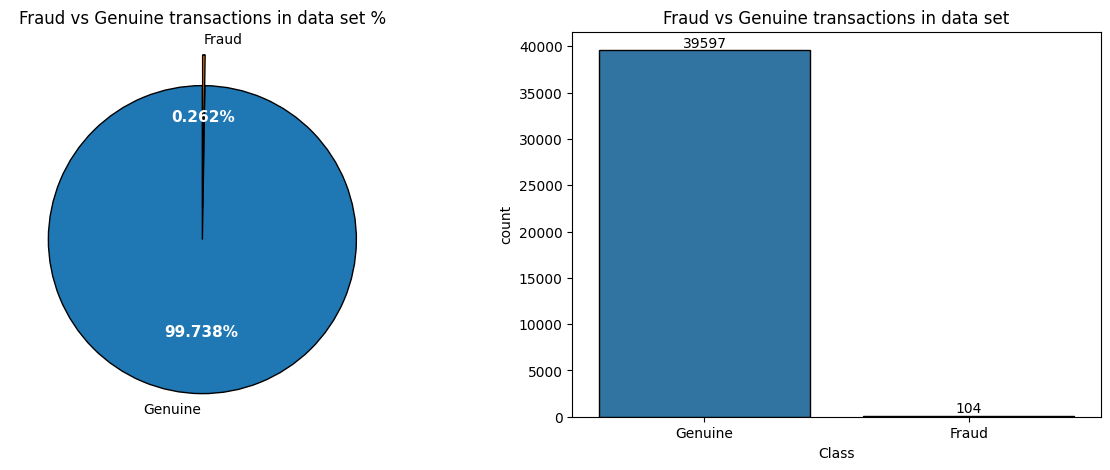

In [30]:
# Show the imbalance in the target variable 'Class'

class_counts = list(df['Class'].value_counts())
pie_values = [class_counts[0] / sum(class_counts) * 100, class_counts[1] / sum(class_counts) * 100]

fig = plt.subplots(nrows = 1,ncols = 2,figsize = (15,5))

plt.subplot(1,2,1)
_, _, autopcts = plt.pie(pie_values,labels = ['Genuine','Fraud'], 
        autopct = '%1.3f%%',
        startangle = 90,
        explode = (0.1,0.1),
        wedgeprops = {'edgecolor': 'black','linewidth': 1, 'antialiased' : True})
plt.title('Fraud vs Genuine transactions in data set %');

plt.setp(autopcts, **{'color':'white', 'weight':'bold', 'fontsize':11})

plt.subplot(1,2,2)
ax = sns.countplot(data = df, 
                   x='Class', 
                   edgecolor = 'black')
for i in ax.containers:
    ax.bar_label(i,)
ax.set_xticklabels(['Genuine','Fraud'])
    
plt.title('Fraud vs Genuine transactions in data set')
plt.show()
plt.close()

## 3.4 Feature Correlation

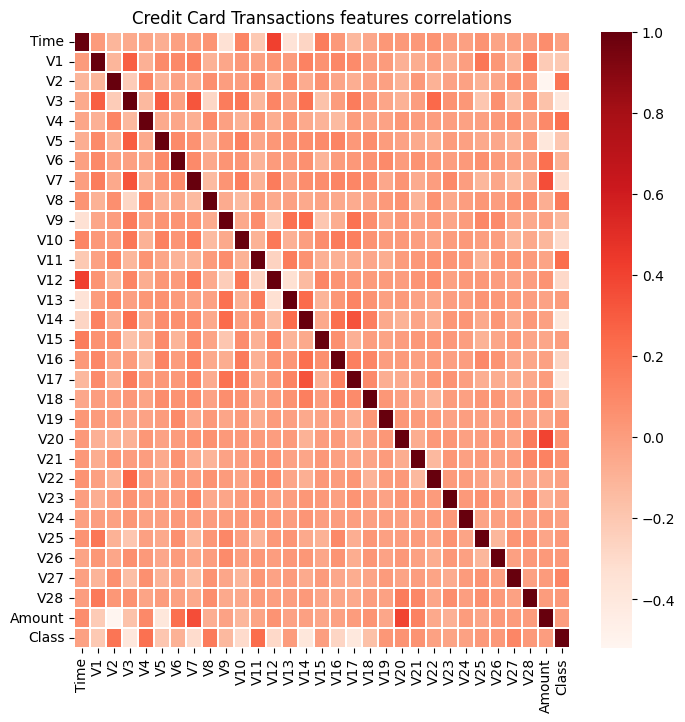

In [31]:
# Use a heatmap to show the correlation between the input variables
plt.figure(figsize = (8,8))
plt.title('Credit Card Transactions features correlations')
corr = df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()
plt.close()

<Figure size 640x480 with 0 Axes>

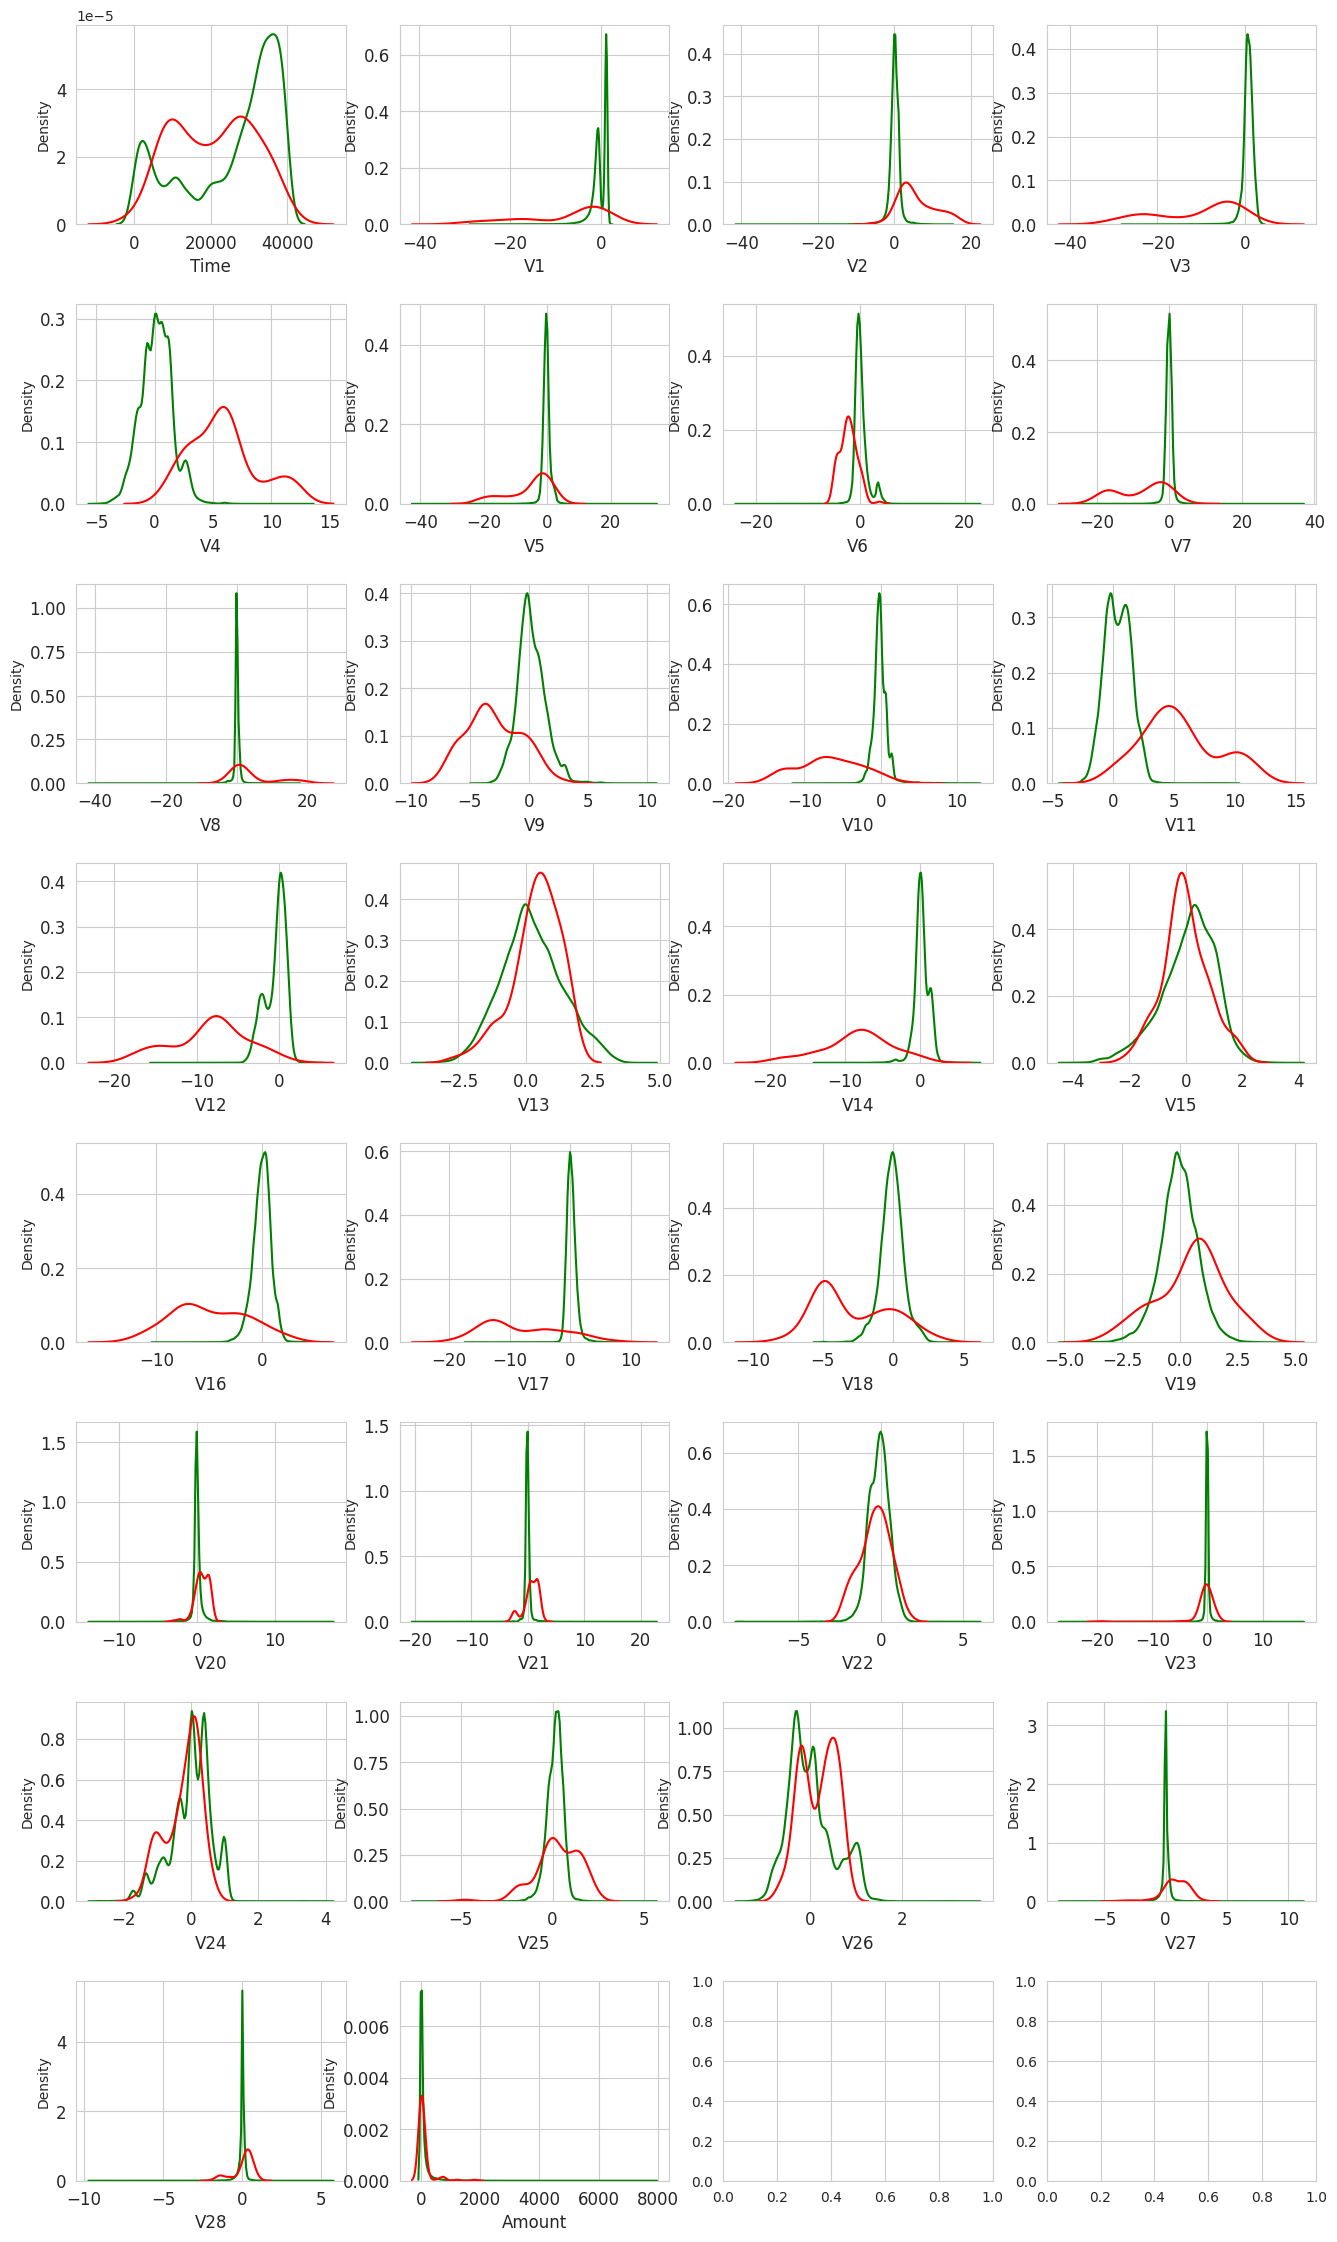

In [49]:
# Look at how each feature's distribution compares between fraud and genuine transactions
# Interested in features where the distributions diverge as this likely indicates a correlation 

# Remove the 'Class' feature as not plotting this
cols = np.delete(df.columns.values, np.where(df.columns.values == 'Class'))
i = 0
genuine = df.loc[df['Class'] == 0]
frauds = df.loc[df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))
plt.subplots_adjust(hspace = 0.4)

for feature in cols:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(genuine[feature],label="0", color='green')
    sns.kdeplot(frauds[feature],label="1", color='red')
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();
plt.close()

A number of features show clear separation of distributions for the Class values 0 and 1. Those that are very similar and therefore have little impact on the class distinction could be dropped from the data to help simplify the model. Examples where the dist is similar are: 
* V13
* V15
* V22
* V23
* V24
* V25
* V26
* V28
* Amount



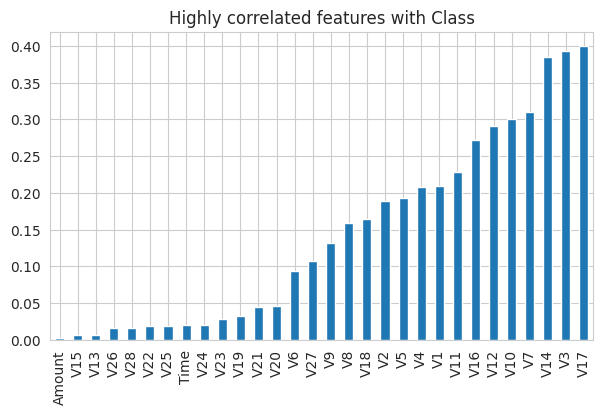

In [50]:
# Another way to look at correlation is with the panda.dataframe.corr() method
plt.figure(figsize=(7,4))
d = df.corr()['Class'][:-1].abs().sort_values().plot(kind='bar',
                    title='Highly correlated features with Class')

# 4. Train, Validation, Test Sets

In [77]:
# First split the df into training and test sets
validation_size = 0.25
test_size = 0.20

X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=11, shuffle=True )

# Then split the training set into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_size, random_state=11, shuffle=True )

# 5. Random Forest Classifier

In [94]:
# Set model parameters

pd.set_option('display.max_columns', 100)

num_jobs = 4 # number of parallel jobs
random_state = 11
rfc_criterion = 'gini' # function to measure the quality of the split
num_estimators = 100 # number of trees in the forest
max_features = 'sqrt' # number of features to use at each split
max_depth = None # max depth of the tree. If None then expanded until all leaves are pure

# Create a helper list of the features
predictors = df.columns.to_list()
predictors.pop(-1)

'Class'

In [95]:
# Initialise the model
clf = RandomForestClassifier(n_jobs=num_jobs, 
                             random_state=random_state,
                             criterion=rfc_criterion,
                             n_estimators=num_estimators,
                             max_features = max_features,
                             max_depth = max_depth,
                             verbose=False)

In [97]:
# Train the RandomForestClassifier using the training data and fit function
clf.fit(X_train, y_train)

# Predict the target values for the validation data, using predict function
preds = clf.predict(X_val)

# Show the score (mean accuracy)
clf.score(X_val, y_val)

0.9994962216624685

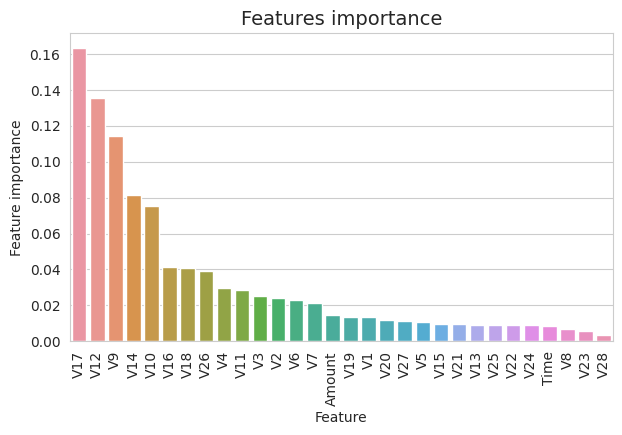

In [98]:
# Visualize the features importance
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 

The most important features are V17, V12, V9, V14

In [99]:
#Let's calculate the ROC-AUC score
roc_auc_score(y_val.values, preds)

0.9410502557706157